In [243]:
import pandas as pd
import numpy as np
import os


# Load and transform country population data from wide to long format
def load_and_transform_population(pop_path='../raw_data/country_population.csv'):
    """
    Load country_population.csv and transform from wide to long format.
    
    Returns:
        df_pop_long : DataFrame with columns [Country Name, Country Code, Year, Population]
    """
    # Load population data
    df_pop = pd.read_csv(pop_path)
    
    print(f"Loaded population data: {df_pop.shape}")
    print(f"Countries: {len(df_pop)}")
    
    # Get year columns (all columns that are numeric - from 1960 to 2016)
    year_columns = [col for col in df_pop.columns if col.isdigit()]
    
    # Transform from wide to long format
    df_pop_long = df_pop.melt(
        id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
        value_vars=year_columns,
        var_name='Year',
        value_name='Population'
    )
    
    # Convert Year to integer and remove rows with missing population
    df_pop_long['Year'] = df_pop_long['Year'].astype(int)
    df_pop_long = df_pop_long[df_pop_long['Population'].notna()].copy()
    
    # Keep only necessary columns and rename Country Code to CCA3 for consistency
    df_pop_long = df_pop_long[['Country Name', 'Country Code', 'Year', 'Population']].copy()
    df_pop_long.rename(columns={'Country Code': 'CCA3'}, inplace=True)
    
    print(f"\nTransformed to long format:")
    print(f"  Shape: {df_pop_long.shape}")
    print(f"  Year range: {df_pop_long['Year'].min()} - {df_pop_long['Year'].max()}")
    print(f"  Countries: {df_pop_long['CCA3'].nunique()}")
    print(f"  Total country-year observations: {len(df_pop_long)}\n")
    
    # Save long-format population data
    output_dir = '../processed_data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df_pop_long.to_csv(os.path.join(output_dir, 'population_long_format.csv'), index=False)
    print(f"Long-format population saved to {output_dir}/population_long_format.csv\n")
    
    return df_pop_long


# Merge population and World Bank data
def merge_population_and_worldbank(pop_path='../raw_data/country_population.csv', 
                                   wb_path='../raw_data/WorldBank.csv'):
    """
    Load population data, transform to long format, and merge with World Bank data.
    
    Returns:
        df_merged : DataFrame with all population and World Bank indicators by country-year
    """
    
    # Load and transform population data
    df_pop = load_and_transform_population(pop_path)
    
    # Load World Bank data
    df_wb = pd.read_csv(wb_path)
    
    # Merge population with World Bank data on Country Code and Year
    df_merged = df_pop.merge(
        df_wb,
        left_on=['CCA3', 'Year'],
        right_on=['Country Code', 'Year'],
        how='inner',
        suffixes=('', '_wb')  # Keep original names from population data, add suffix to World Bank duplicates
    )
    
    # Ensure we have Country Name from population data
    # If there's a duplicate, rename appropriately
    if 'Country Name_wb' in df_merged.columns and 'Country Name' not in df_merged.columns:
        df_merged['Country Name'] = df_merged['Country Name_wb']
    
    # Reset index
    df_merged = df_merged.reset_index(drop=True)
    
    print(f"Merged data shape: {df_merged.shape}")
    print(f"Year range: {df_merged['Year'].min()} - {df_merged['Year'].max()}")
    print(f"Number of countries: {df_merged['CCA3'].nunique()}")
    print(f"Number of country-year observations: {len(df_merged)}\n")
    
    # Save merged data
    output_dir = '../processed_data'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df_merged.to_csv(os.path.join(output_dir, 'raw_merged_data.csv'), index=False)
    print(f"Merged data saved to {output_dir}/raw_merged_data.csv\n")
    
    return df_merged


###############################################
# Select valuable features for prediction
###############################################
def select_features_for_prediction(df_merged):
    """
    Select valuable features from merged data for predicting population growth.
    
    Returns:
        X_features : DataFrame of selected features
        y : Target variable (population)
        meta : DataFrame with country and year identifiers
    """
    
    # Keep only rows with non-null population
    df_clean = df_merged[df_merged['Population'].notna()].copy()
    
    # Select valuable features for prediction
    feature_cols = [
        'Birth rate, crude (per 1,000 people)',
        'Death rate, crude (per 1,000 people)',
        'Life expectancy at birth (years)',
        'GDP per capita (USD)',
        'GDP (USD)',
        'Population density (people per sq. km of land area)',
        'Electric power consumption (kWh per capita)',
        'Individuals using the Internet (% of population)',
        'Infant mortality rate (per 1,000 live births)',
        'Unemployment (% of total labor force) (modeled ILO estimate)',
        'Growth Rate'
    ]
    
    # Create feature matrix with available columns
    X_features = pd.DataFrame()
    
    for col in feature_cols:
        if col in df_clean.columns:
            X_features[col] = df_clean[col]
    
    # Add temporal feature
    X_features['Year'] = df_clean['Year']
    
    # Add categorical features
    X_features['Region'] = df_clean['Region']
    X_features['IncomeGroup'] = df_clean['IncomeGroup']
    
    # Target variable: Population
    y = df_clean['Population'].values
    
    # Meta information for tracking
    meta = df_clean[['Country Name', 'CCA3', 'Region', 'IncomeGroup', 'Year']].copy()
    
    print(f"Selected features: {X_features.shape[1]} features")
    print(f"Observations: {X_features.shape[0]}")
    print(f"Missing values per column:")
    missing_pct = (X_features.isnull().sum() / len(X_features) * 100).round(2)
    for col in X_features.columns:
        if missing_pct[col] > 0:
            print(f"  {col}: {missing_pct[col]}%")
    print()
    
    return X_features, y, meta, df_clean


###############################################
# Prepare data for future growth prediction with specific horizons
###############################################
def prepare_future_growth_training_data(df_merged, target_horizons=[5, 10, 15]):
    """
    Prepare training data for predicting population growth at specific future horizons.
    
    For each country-year pair in the merged data, create training samples for:
        - 5 years ahead
        - 10 years ahead
        - 15 years ahead
    
    Only creates samples where future data exists (e.g., if base year is 2012, 
    we can create samples for 5 years (2017) but not for 20 years (2032) if data ends at 2016).

    Args:
        df_merged: Merged DataFrame with population and World Bank indicators
        target_horizons: List of years ahead to predict (default: [5, 10, 15, 20])

    Returns:
        X_train   : Feature matrix (current-year features + years_ahead)
        y_train   : Growth rate to future year (%)
        meta_train: Metadata (country, base year, future year, horizon)
    """

    # Sort by country and year for safety
    df_sorted = df_merged.sort_values(["CCA3", "Year"]).reset_index(drop=True)

    # Only use rows with known population
    df_clean = df_sorted[df_sorted["Population"].notna()].copy()

    X_train_rows = []
    y_train = []
    meta_rows = []

    # Create a lookup dictionary for faster access: (country, year) -> row data
    country_year_dict = {}
    for idx, row in df_clean.iterrows():
        key = (row["CCA3"], row["Year"])
        country_year_dict[key] = row

    print(f"\nProcessing {len(df_clean)} country-year pairs...")
    print(f"Target horizons: {target_horizons} years ahead")
    
    samples_created = {h: 0 for h in target_horizons}
    
    # For each country-year pair, try to create samples for each target horizon
    for idx, base_row in df_clean.iterrows():
        country_code = base_row["CCA3"]
        base_year = base_row["Year"]
        base_pop = base_row["Population"]
        
        # Try each target horizon
        for years_ahead in target_horizons:
            future_year = base_year + years_ahead
            future_key = (country_code, future_year)
            
            # Check if future data exists
            if future_key in country_year_dict:
                future_row = country_year_dict[future_key]
                future_pop = future_row["Population"]
                
                # Compute actual growth rate
                growth_rate = ((future_pop - base_pop) / base_pop) * 100
                
                # Build feature vector using data from the base year
                X_train_rows.append({
                    "Population": base_pop,
                    "Birth rate": base_row.get("Birth rate, crude (per 1,000 people)", np.nan),
                    "Death rate": base_row.get("Death rate, crude (per 1,000 people)", np.nan),
                    "Life expectancy": base_row.get("Life expectancy at birth (years)", np.nan),
                    "GDP per capita": base_row.get("GDP per capita (USD)", np.nan),
                    "GDP": base_row.get("GDP (USD)", np.nan),
                    "Density": base_row.get("Population density (people per sq. km of land area)", np.nan),
                    "Year": base_year,
                    "Years ahead": years_ahead,
                    "Region": base_row.get("Region", "Unknown")
                })
                
                # Target
                y_train.append(growth_rate)
                
                # Metadata
                meta_rows.append({
                    "Country Name": base_row["Country Name"],
                    "CCA3": country_code,
                    "Region": base_row.get("Region", "Unknown"),
                    "IncomeGroup": base_row.get("IncomeGroup", "Unknown"),
                    "Base Year": int(base_year),
                    "Future Year": int(future_year),
                    "Years Ahead": int(years_ahead)
                })
                
                samples_created[years_ahead] += 1

    # Convert lists to structured outputs
    X_train = pd.DataFrame(X_train_rows)
    y_train = np.array(y_train)
    meta_train = pd.DataFrame(meta_rows)

    # Print summary
    print("\nFuture-growth training data prepared:")
    print(f"  Total samples: {len(y_train):,}")
    print(f"  Feature matrix: {X_train.shape}")
    print(f"  Countries: {meta_train['CCA3'].nunique()}")
    print(f"  Base years covered: {meta_train['Base Year'].min()} to {meta_train['Base Year'].max()}")
    print(f"\nSamples by prediction horizon:")
    for horizon in sorted(target_horizons):
        count = samples_created[horizon]
        pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
        pct_rounded = round(pct, 1)
        print(f"    {horizon} years ahead: {count:,} samples ({pct_rounded}%)")
    print()

    return X_train, y_train, meta_train



# 1. Merge population and World Bank data
print("Merging population and World Bank data...")
df_merged = merge_population_and_worldbank()

# 2. Select valuable features
print("Selecting valuable features...")
X_features, y, meta, df_clean = select_features_for_prediction(df_merged)



# 3. Prepare data for future growth prediction at specific horizons
print("Preparing data for population growth rate prediction...")
# Create training samples for 5, 10, and 15 years ahead from each country-year pair
X_train, y_train, meta_train = prepare_future_growth_training_data(df_merged, target_horizons=[5, 10, 15])

Merging population and World Bank data...
Loaded population data: (264, 61)
Countries: 264

Transformed to long format:
  Shape: (14885, 4)
  Year range: 1960 - 2016
  Countries: 263
  Total country-year observations: 14885

Long-format population saved to ../processed_data/population_long_format.csv

Merged data shape: (11921, 18)
Year range: 1960 - 2016
Number of countries: 211
Number of country-year observations: 11921

Merged data saved to ../processed_data/raw_merged_data.csv

Selecting valuable features...
Selected features: 13 features
Observations: 11921
Missing values per column:
  Birth rate, crude (per 1,000 people): 5.77%
  Death rate, crude (per 1,000 people): 5.97%
  Life expectancy at birth (years): 7.96%
  GDP per capita (USD): 22.86%
  GDP (USD): 22.86%
  Population density (people per sq. km of land area): 4.09%
  Electric power consumption (kWh per capita): 50.96%
  Individuals using the Internet (% of population): 59.88%
  Infant mortality rate (per 1,000 live birth

In [244]:
# Import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


## Data Quality Filtering

Before splitting the data, we'll remove rows with too many missing values to ensure high-quality training data.

In [245]:
###############################################
# Data Quality Check - Remove rows with too many NaNs
###############################################

print("\n" + "="*70)
print("DATA QUALITY FILTERING")
print("="*70)

# Check missing values before filtering
print(f"\nBefore filtering:")
print(f"  Total samples: {len(X_train)}")
print(f"\nMissing values per feature:")
missing_counts = X_train.isnull().sum()
missing_pct = (missing_counts / len(X_train) * 100)
for col in X_train.columns:
    if missing_counts[col] > 0:
        pct_rounded = round(missing_pct[col], 1)
        print(f"  {col}: {missing_counts[col]} ({pct_rounded}%)")

# Calculate percentage of NaN values per row
nan_percentage_per_row = X_train.isnull().sum(axis=1) / X_train.shape[1] * 100

# Set threshold: remove rows with more than 30% missing values
nan_threshold = 30  # percentage

print(f"\nFiltering strategy:")
print(f"  Threshold: Remove rows with > {nan_threshold}% missing values")

# Identify rows to keep
rows_to_keep = nan_percentage_per_row <= nan_threshold

removed_count = (~rows_to_keep).sum()
removed_pct = round((removed_count / len(X_train)) * 100, 1)
print(f"\nRows with > {nan_threshold}% NaN: {removed_count} ({removed_pct}%)")

# Filter the data
X_train_clean = X_train[rows_to_keep].copy()
y_train_clean = y_train[rows_to_keep].copy()
meta_train_clean = meta_train[rows_to_keep].reset_index(drop=True)

retention_rate = round((len(X_train_clean) / len(X_train)) * 100, 1)
print(f"\nAfter filtering:")
print(f"  Remaining samples: {len(X_train_clean)}")
print(f"  Removed samples: {len(X_train) - len(X_train_clean)}")
print(f"  Retention rate: {retention_rate}%")

# Show distribution of missing values per row
print(f"\nMissing value distribution (after filtering):")
nan_pct_clean = X_train_clean.isnull().sum(axis=1) / X_train_clean.shape[1] * 100
mean_nan = round(nan_pct_clean.mean(), 1)
max_nan = round(nan_pct_clean.max(), 1)
zero_nan_count = (nan_pct_clean == 0).sum()
zero_nan_pct = round((zero_nan_count / len(X_train_clean)) * 100, 1)
low_nan_count = (nan_pct_clean < 10).sum()
low_nan_pct = round((low_nan_count / len(X_train_clean)) * 100, 1)

print(f"  Mean NaN per row: {mean_nan}%")
print(f"  Max NaN per row: {max_nan}%")
print(f"  Rows with 0% NaN: {zero_nan_count} ({zero_nan_pct}%)")
print(f"  Rows with < 10% NaN: {low_nan_count} ({low_nan_pct}%)")

# Update variables for downstream use
X_train = X_train_clean
y_train = y_train_clean
meta_train = meta_train_clean

print(f"\nData quality filtering complete!")
print("="*70)


DATA QUALITY FILTERING

Before filtering:
  Total samples: 29424

Missing values per feature:
  Birth rate: 1802 (6.1%)
  Death rate: 1869 (6.4%)
  Life expectancy: 2436 (8.3%)
  GDP per capita: 7896 (26.8%)
  GDP: 7896 (26.8%)
  Density: 1404 (4.8%)

Filtering strategy:
  Threshold: Remove rows with > 30% missing values

Rows with > 30% NaN: 1268 (4.3%)

After filtering:
  Remaining samples: 28156
  Removed samples: 1268
  Retention rate: 95.7%

Missing value distribution (after filtering):
  Mean NaN per row: 5.9%
  Max NaN per row: 30.0%
  Rows with 0% NaN: 19893 (70.7%)
  Rows with < 10% NaN: 19893 (70.7%)

Data quality filtering complete!


In [246]:
###############################################
# Note: Train-Test Split Done Later (Temporal Split)
###############################################

# IMPORTANT: We do NOT do a random train-test split here!
# 
# Random splitting would mix past and future years, causing temporal leakage.
# Instead, we will do a TEMPORAL split in the next cell:
#   - Training: All samples with base years ≤ 2010
#   - Test: All samples with base years > 2010
#
# This ensures the model learns from the past and is tested on the future,
# which is how real-world forecasting works.

print("\n" + "="*70)
print("SKIPPING RANDOM TRAIN-TEST SPLIT")
print("="*70)
print("\nRandom split would cause temporal leakage!")
print("Will use temporal split instead (next cell)")
print(f"\nCurrent data ready for temporal split:")
print(f"  Total samples: {len(X_train)}")
print(f"  Years covered: {meta_train['Base Year'].min()} - {meta_train['Base Year'].max()}")
print("="*70)


SKIPPING RANDOM TRAIN-TEST SPLIT

Random split would cause temporal leakage!
Will use temporal split instead (next cell)

Current data ready for temporal split:
  Total samples: 28156
  Years covered: 1960 - 2011


## Addressing Temporal Leakage Risk

**Problem**: Random train-test split can mix future and past years, leading to optimistic results.

**Solution**: We implement a **temporal train-test split** to prevent temporal leakage:
- **Training Set**: All samples with base years ≤ 2010
- **Test Set**: All samples with base years > 2010

This ensures the model is trained on historical data and evaluated on more recent years, mimicking real-world forecasting where we predict forward in time.


### Correct Data Processing Order (No Leakage)

**Our Pipeline**:
1. **Data Quality Filtering** → Remove rows with >30% missing values
2. **Skip Random Split** → Would cause temporal leakage!
3. **Temporal Train-Test Split** → Split by year (≤2010 / >2010)
4. **Outlier Removal** → Fit Isolation Forest on training set only
5. **Cross-Validation** → TimeSeriesSplit maintains temporal order
6. **Final Training** → Train on past, test on future

**Why This Order Prevents Leakage**:
- Temporal split happens BEFORE outlier removal
- Test set never seen during outlier detection
- No future data in training at any stage
- All decisions made using only training data


In [247]:
###############################################
# Temporal Train-Test Split (Prevents Temporal Leakage)
###############################################

print("\n" + "="*70)
print("TEMPORAL TRAIN-TEST SPLIT")
print("="*70)

# Reset indices to align X_train, y_train, and meta_train after filtering/outlier removal
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = pd.Series(y_train).reset_index(drop=True)
meta_train_reset = meta_train.reset_index(drop=True)

# Define temporal cutoff: train on years <= 2010, test on years > 2010
temporal_cutoff = 2010

# Create masks based on Base Year
train_mask = meta_train_reset['Base Year'] <= temporal_cutoff
test_mask = meta_train_reset['Base Year'] > temporal_cutoff

# Apply temporal split
X_train_temporal = X_train_reset[train_mask].reset_index(drop=True)
y_train_temporal = y_train_reset[train_mask].values
X_test_temporal = X_train_reset[test_mask].reset_index(drop=True)
y_test_temporal = y_train_reset[test_mask].values

# Get year ranges for reporting
train_years = meta_train_reset[train_mask]['Base Year']
test_years = meta_train_reset[test_mask]['Base Year']

print(f"\nTemporal Split Strategy:")
print(f"  Cutoff Year: {temporal_cutoff}")
print(f"  Training Set: Base years ≤ {temporal_cutoff}")
print(f"  Test Set: Base years > {temporal_cutoff}")

print(f"\nTemporal Split Results:")
print(f"  Training samples: {len(X_train_temporal)} (years {train_years.min()}-{train_years.max()})")
print(f"  Test samples: {len(X_test_temporal)} (years {test_years.min()}-{test_years.max()})")

train_pct = round(len(X_train_temporal) / (len(X_train_temporal) + len(X_test_temporal)) * 100, 1)
test_pct = round(len(X_test_temporal) / (len(X_train_temporal) + len(X_test_temporal)) * 100, 1)

print(f"  Train/Test ratio: {train_pct}% / {test_pct}%")

print(f"\n✓ Temporal leakage prevented: Model trained only on past data")
print(f"✓ Test set contains only future years unseen during training")

# Update variables for downstream use
X_train = X_train_temporal
y_train = y_train_temporal
X_test = X_test_temporal
y_test = y_test_temporal

# Also update metadata to match the temporal split
meta_train = meta_train_reset[train_mask].reset_index(drop=True)
meta_test = meta_train_reset[test_mask].reset_index(drop=True)

print("="*70)



TEMPORAL TRAIN-TEST SPLIT

Temporal Split Strategy:
  Cutoff Year: 2010
  Training Set: Base years ≤ 2010
  Test Set: Base years > 2010

Temporal Split Results:
  Training samples: 27946 (years 1960-2010)
  Test samples: 210 (years 2011-2011)
  Train/Test ratio: 99.3% / 0.7%

✓ Temporal leakage prevented: Model trained only on past data
✓ Test set contains only future years unseen during training


## Outlier Detection and Removal (Training Set Only)

We'll use **Isolation Forest** to identify and remove outliers **only from the training set** to prevent data leakage:
- **Isolation Forest**: ML-based anomaly detection that analyzes patterns across all numeric features
- Identifies anomalies by isolating observations through random partitioning
- Uses 5% contamination threshold (expects ~5% of data to be outliers)

**Important**: Isolation Forest is fit only on training data and test set remains unchanged.


OUTLIER DETECTION AND REMOVAL (TRAINING SET ONLY)

Before outlier removal:
  Training samples: 27946
  Test samples: 210 (will remain unchanged)
  Training growth rate range: -23.29% to 598.57%

----------------------------------------------------------------------
ISOLATION FOREST (Anomaly Detection)
----------------------------------------------------------------------
  Contamination threshold: 5%
  Outliers detected in training: 1398 (5.0%)
  ✓ Model fitted only on training data (no data leakage)

----------------------------------------------------------------------
REMOVING OUTLIERS FROM TRAINING SET (TEST SET UNCHANGED)
----------------------------------------------------------------------

After outlier removal:
  Training samples remaining: 26548
  Training samples removed: 1398
  Training retention rate: 95.0%
  Test samples: 210 (unchanged - no data leakage)

Training growth rate statistics (after removal):
  Min: -23.29%
  Max: 598.57%
  Mean: 21.06%
  Std: 25.95%


/var/folders/st/mw9xgfks1mzbqy9srk1cd9500000gp/T/ipykernel_3202/4174404938.py:95: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[2].boxplot(box_data, labels=['Train Before', 'Train After', 'Test (Unchanged)'], patch_artist=True)


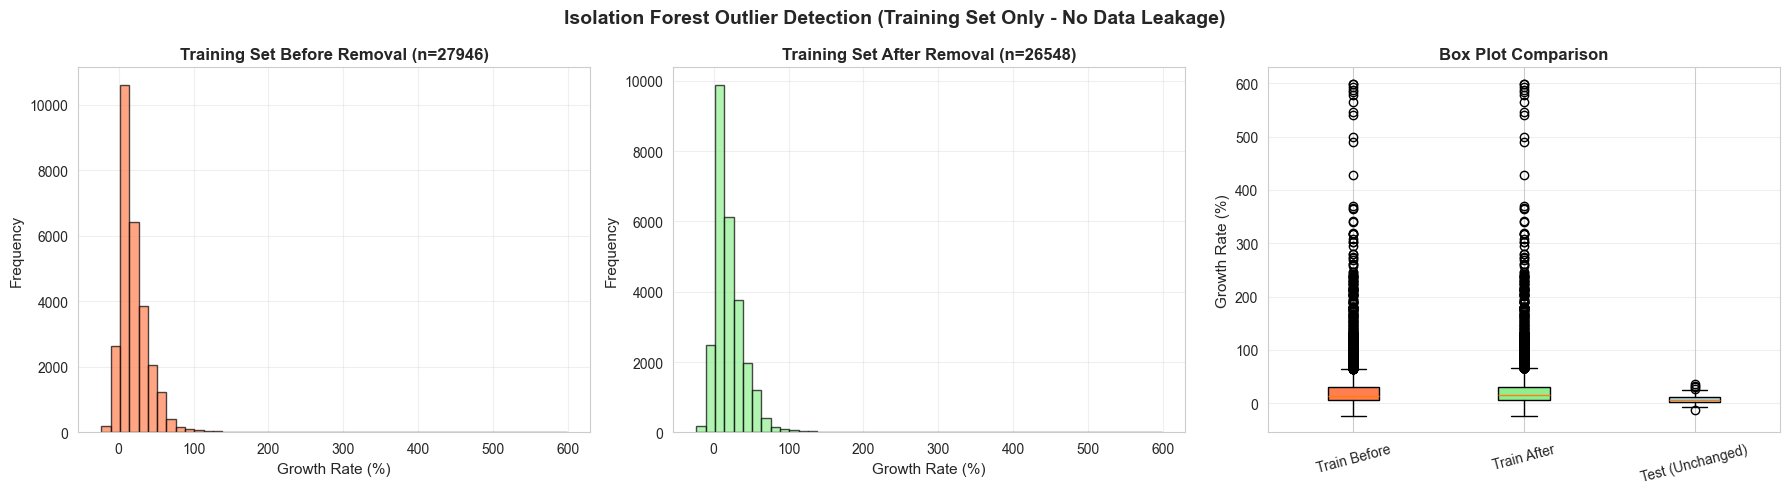


Visualization saved to '../processed_data/outlier_detection.png'

OUTLIER REMOVAL COMPLETE - NO DATA LEAKAGE
    Isolation Forest fitted only on training data
    Test set remains completely unchanged (210 samples)
    Meta_train also filtered to maintain alignment (26548 samples)


In [248]:
###############################################
# Outlier Detection and Removal (Training Set Only)
###############################################

print("\n" + "="*70)
print("OUTLIER DETECTION AND REMOVAL (TRAINING SET ONLY)")
print("="*70)

from sklearn.ensemble import IsolationForest

min_growth = round(y_train.min(), 2)
max_growth = round(y_train.max(), 2)
print(f"\nBefore outlier removal:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)} (will remain unchanged)")
print(f"  Training growth rate range: {min_growth}% to {max_growth}%")

# Store original training data for comparison
X_train_before_outliers = X_train.copy()
y_train_before_outliers = y_train.copy()

# Isolation Forest on Features (Training Only)
print("\n" + "-"*70)
print("ISOLATION FOREST (Anomaly Detection)")
print("-"*70)

# Use only numeric features for Isolation Forest
X_train_numeric = X_train.select_dtypes(include=[np.number]).copy()

# Fill NaN for Isolation Forest (it can't handle missing values)
X_train_numeric_filled = X_train_numeric.fillna(X_train_numeric.median())

# Train Isolation Forest on TRAINING DATA ONLY
isolation_forest = IsolationForest(
    contamination=0.05,  # Expect 5% outliers
    random_state=42,
    n_jobs=-1
)

# Fit only on training data
isolation_forest_predictions = isolation_forest.fit_predict(X_train_numeric_filled)
outliers = isolation_forest_predictions == -1  # -1 indicates outliers

outlier_pct = round((outliers.sum() / len(y_train)) * 100, 1)
print(f"  Contamination threshold: 5%")
print(f"  Outliers detected in training: {outliers.sum()} ({outlier_pct}%)")
print(f"  ✓ Model fitted only on training data (no data leakage)")

print("\n" + "-"*70)
print("REMOVING OUTLIERS FROM TRAINING SET (TEST SET UNCHANGED)")
print("-"*70)

# Keep only non-outliers in training set
inliers_mask = ~outliers

X_train_no_outliers = X_train[inliers_mask].copy()
y_train_no_outliers = y_train[inliers_mask].copy()

retention = round((len(X_train_no_outliers) / len(X_train)) * 100, 1)
print(f"\nAfter outlier removal:")
print(f"  Training samples remaining: {len(X_train_no_outliers)}")
print(f"  Training samples removed: {outliers.sum()}")
print(f"  Training retention rate: {retention}%")
print(f"  Test samples: {len(X_test)} (unchanged - no data leakage)")

min_val = round(y_train_no_outliers.min(), 2)
max_val = round(y_train_no_outliers.max(), 2)
mean_val = round(y_train_no_outliers.mean(), 2)
std_val = round(y_train_no_outliers.std(), 2)
print(f"\nTraining growth rate statistics (after removal):")
print(f"  Min: {min_val}%")
print(f"  Max: {max_val}%")
print(f"  Mean: {mean_val}%")
print(f"  Std: {std_val}%")

# VISUALIZATION: Before vs After Outlier Removal
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Distribution before removal
axes[0].hist(y_train_before_outliers, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Growth Rate (%)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title(f'Training Set Before Removal (n={len(y_train_before_outliers)})', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Distribution after removal
axes[1].hist(y_train_no_outliers, bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Growth Rate (%)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title(f'Training Set After Removal (n={len(y_train_no_outliers)})', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Plot 3: Box plot comparison (include test set for reference)
box_data = [y_train_before_outliers, y_train_no_outliers, y_test]
bp = axes[2].boxplot(box_data, labels=['Train Before', 'Train After', 'Test (Unchanged)'], patch_artist=True)
bp['boxes'][0].set_facecolor('coral')
bp['boxes'][1].set_facecolor('lightgreen')
bp['boxes'][2].set_facecolor('lightblue')
axes[2].set_ylabel('Growth Rate (%)', fontsize=11)
axes[2].set_title('Box Plot Comparison', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=15)

plt.suptitle('Isolation Forest Outlier Detection (Training Set Only - No Data Leakage)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../processed_data/outlier_detection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to '../processed_data/outlier_detection.png'")

# Update training variables for downstream use (test set remains unchanged)
X_train = X_train_no_outliers
y_train = y_train_no_outliers
# IMPORTANT: Also update meta_train to keep it aligned with X_train and y_train
meta_train = meta_train[inliers_mask].reset_index(drop=True)

print(f"\n" + "="*70)
print("OUTLIER REMOVAL COMPLETE - NO DATA LEAKAGE")
print(f"    Isolation Forest fitted only on training data")
print(f"    Test set remains completely unchanged ({len(X_test)} samples)")
print(f"    Meta_train also filtered to maintain alignment ({len(meta_train)} samples)")
print("="*70)


TEMPORAL CROSS-VALIDATION, FINAL TRAINING & TEST EVALUATION

Performing TEMPORAL 5-fold cross-validation on 3 baseline models...
Number of training samples: 26548
CV strategy: TimeSeriesSplit (respects time ordering)
Evaluation metric: RMSE (Root Mean Squared Error)

Cross-validating Linear Regression...
  Mean CV RMSE: 16.36% (±3.11%)
Cross-validating Random Forest...
  Mean CV RMSE: 16.36% (±3.11%)
Cross-validating Random Forest...
  Mean CV RMSE: 19.09% (±2.67%)
Cross-validating Gradient Boosting...
  Mean CV RMSE: 19.09% (±2.67%)
Cross-validating Gradient Boosting...
  Mean CV RMSE: 22.51% (±4.2%)

TEMPORAL CROSS-VALIDATION RESULTS SUMMARY (BASELINE MODELS)

✓ Temporal CV completed with no temporal leakage
  Each fold trains on past data and validates on future data

Model                     Mean RMSE       Std Dev         95% CI              
---------------------------------------------------------------------------
Linear Regression         16.36% *         ±3.11%         [10.

/var/folders/st/mw9xgfks1mzbqy9srk1cd9500000gp/T/ipykernel_3202/650607155.py:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(cv_data, labels = list(candidate_models.keys()), patch_artist = True)


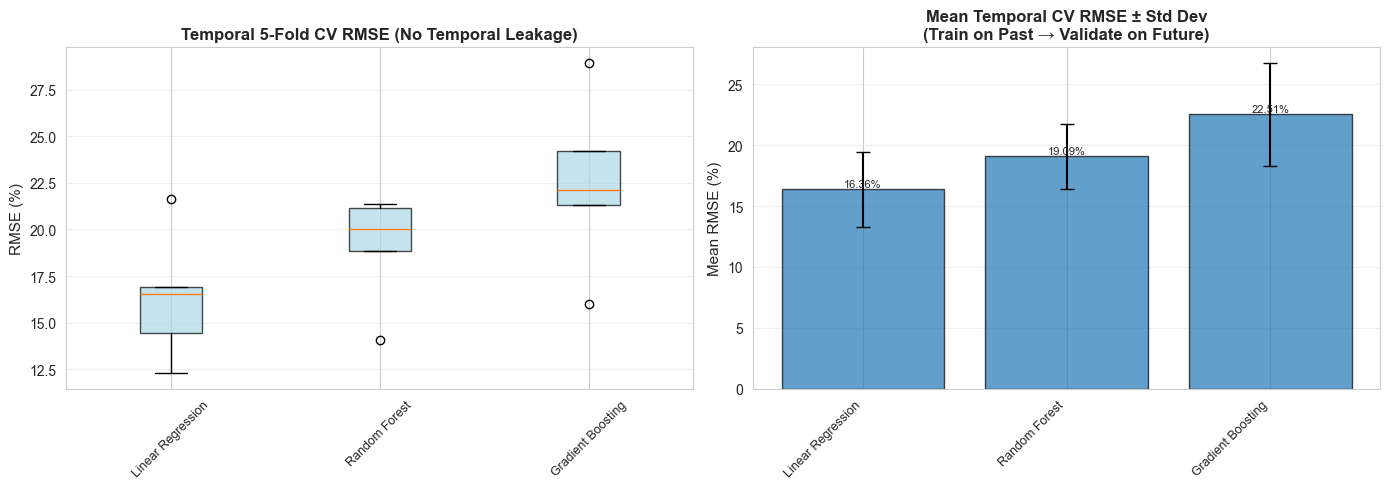


Temporal cross-validation visualization saved to '../processed_data/cross_validation_results.png'

Running temporal CV for stacked model (Lasso + RF → Ridge)...
  Stacked model mean CV RMSE: 15.86% (±2.23%)

FINAL MODEL TRAINING & TEST SET EVALUATION
Training Linear Regression...
  Stacked model mean CV RMSE: 15.86% (±2.23%)

FINAL MODEL TRAINING & TEST SET EVALUATION
Training Linear Regression...
  Train RMSE: 20.47%  |  Test RMSE: 13.76%
  Train MAE:  9.62%  |  Test MAE:  8.52%
Training Random Forest...
  Train RMSE: 20.47%  |  Test RMSE: 13.76%
  Train MAE:  9.62%  |  Test MAE:  8.52%
Training Random Forest...
  Train RMSE: 7.62%  |  Test RMSE: 8.32%
  Train MAE:  4.33%  |  Test MAE:  3.11%
Training Gradient Boosting...
  Train RMSE: 7.62%  |  Test RMSE: 8.32%
  Train MAE:  4.33%  |  Test MAE:  3.11%
Training Gradient Boosting...
  Train RMSE: 4.11%  |  Test RMSE: 7.66%
  Train MAE:  2.63%  |  Test MAE:  3.17%
Training Stacked Lasso + RF...
  Train RMSE: 4.11%  |  Test RMSE: 7.66%


In [249]:
###############################################
# Temporal CV, Stacked Model Training, and Test Evaluation
###############################################

print("\n" + "=" * 70)
print("TEMPORAL CROSS-VALIDATION, FINAL TRAINING & TEST EVALUATION")
print("=" * 70)

# Core sklearn + metrics imports for this stage
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------
# 1. Temporal CV for the baseline models
#    (Linear, RF, Gradient Boosting)
# -------------------------------------------------

# The numeric columns we feed into the imputer + scaler
numeric_features = [
    'Population',
    'Birth rate',
    'Death rate',
    'Life expectancy',
    'GDP per capita',
    'GDP',
    'Density',
    'Year',
    'Years ahead'
]

# Shared preprocessing: KNN imputer + StandardScaler on numeric features
preprocessor_cv = ColumnTransformer(
    transformers = [
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors = 5)),
            ('scaler', StandardScaler())
        ]), numeric_features)
    ]
)

# Baseline models, each wrapped in a pipeline with the same preprocessor
candidate_models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor_cv),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor_cv),
        ('model', RandomForestRegressor(
            n_estimators = 500,
            max_depth = 10,
            random_state = 42,
            n_jobs = -1
        ))
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor_cv),
        ('model', GradientBoostingRegressor(
            n_estimators = 500,
            max_depth = 5,
            learning_rate = 0.1,
            random_state = 42
        ))
    ])
}

# Time-aware CV: each fold trains on earlier years and validates on later years
tscv = TimeSeriesSplit(n_splits = 5)

print(f"\nPerforming TEMPORAL 5-fold cross-validation on {len(candidate_models)} baseline models...")
print(f"Number of training samples: {len(X_train)}")
print("CV strategy: TimeSeriesSplit (respects time ordering)")
print("Evaluation metric: RMSE (Root Mean Squared Error)\n")

cv_results = {}

for model_name, pipeline in candidate_models.items():
    print(f"Cross-validating {model_name}...")
    
    cv_scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv = tscv,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1
    )
    
    # Turn negative MSE into RMSE
    cv_rmse_scores = np.sqrt(-cv_scores)
    mean_rmse = cv_rmse_scores.mean()
    std_rmse = cv_rmse_scores.std()
    
    cv_results[model_name] = {
        'cv_scores': cv_rmse_scores,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse
    }
    
    print(f"  Mean CV RMSE: {round(mean_rmse, 2)}% (±{round(std_rmse, 2)}%)")


best_cv_model = min(cv_results.keys(), key = lambda k: cv_results[k]['mean_rmse'])
best_cv_rmse = round(cv_results[best_cv_model]['mean_rmse'], 2)

print("\n" + "=" * 70)
print("TEMPORAL CROSS-VALIDATION RESULTS SUMMARY (BASELINE MODELS)")
print("=" * 70)
print("\n✓ Temporal CV completed with no temporal leakage")
print("  Each fold trains on past data and validates on future data\n")

print(f"{'Model':<25} {'Mean RMSE':<15} {'Std Dev':<15} {'95% CI':<20}")
print("-" * 75)

for model_name in candidate_models.keys():
    mean_rmse = cv_results[model_name]['mean_rmse']
    std_rmse = cv_results[model_name]['std_rmse']
    
    ci_lower = mean_rmse - 1.96 * std_rmse
    ci_upper = mean_rmse + 1.96 * std_rmse
    
    mean_r = round(mean_rmse, 2)
    std_r = round(std_rmse, 2)
    ci_l_r = round(ci_lower, 2)
    ci_u_r = round(ci_upper, 2)
    
    # Highlight the best baseline with a star
    marker = " *" if model_name == best_cv_model else "  "
    
    print(f"{model_name:<25} {mean_r}%{marker:<10} ±{std_r}%{' ':<8} [{ci_l_r}%, {ci_u_r}%]")

print(f"\nBest baseline (by temporal CV): {best_cv_model}  (mean RMSE = {best_cv_rmse}%)")

# ---- Optional: visualization of baseline CV performance ----
fig, axes = plt.subplots(1, 2, figsize = (14, 5))

# Boxplot of fold-level RMSE for each model
ax1 = axes[0]
cv_data = [cv_results[m]['cv_scores'] for m in candidate_models.keys()]
bp = ax1.boxplot(cv_data, labels = list(candidate_models.keys()), patch_artist = True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax1.set_ylabel('RMSE (%)', fontsize = 11)
ax1.set_title('Temporal 5-Fold CV RMSE (No Temporal Leakage)', fontsize = 12, fontweight = 'bold')
ax1.tick_params(axis = 'x', rotation = 45, labelsize = 9)
ax1.grid(alpha = 0.3, axis = 'y')

# Bar chart of mean RMSE ± std for each model
ax2 = axes[1]
x_pos = np.arange(len(candidate_models))
means = [cv_results[m]['mean_rmse'] for m in candidate_models.keys()]
stds = [cv_results[m]['std_rmse'] for m in candidate_models.keys()]

bars = ax2.bar(x_pos, means, yerr = stds, alpha = 0.7, capsize = 5, edgecolor = 'black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(list(candidate_models.keys()), rotation = 45, ha = 'right', fontsize = 9)
ax2.set_ylabel('Mean RMSE (%)', fontsize = 11)
ax2.set_title('Mean Temporal CV RMSE ± Std Dev\n(Train on Past → Validate on Future)', fontsize = 12, fontweight = 'bold')
ax2.grid(alpha = 0.3, axis = 'y')

# Put numeric labels on top of each bar
for bar, mean in zip(bars, means):
    ax2.text(
        bar.get_x() + bar.get_width() / 2.,
        bar.get_height(),
        f'{mean:.2f}%',
        ha = 'center',
        va = 'bottom',
        fontsize = 8
    )

plt.tight_layout()
plt.savefig('../processed_data/cross_validation_results.png', dpi = 150, bbox_inches = 'tight')
plt.show()

print("\nTemporal cross-validation visualization saved to '../processed_data/cross_validation_results.png'")

# -------------------------------------------------
# 2. Define the stacked model:
#    Lasso + Random Forest  → Ridge meta-learner
#    (all wrapped with the same preprocessor_cv)
# -------------------------------------------------

# Base learners (these operate on the preprocessed features)
stack_base_estimators = [
    ('lasso', Lasso(alpha = 0.001, max_iter = 10000)),
    ('rf', RandomForestRegressor(
        n_estimators = 500,
        max_depth = None,
        min_samples_leaf = 1,
        max_features = 0.5,
        random_state = 0,
        n_jobs = -1
    ))
]

# Final meta-learner that learns how to combine Lasso and RF predictions
stack_final_estimator = Ridge(alpha = 0.1)

stack_regressor = StackingRegressor(
    estimators = stack_base_estimators,
    final_estimator = stack_final_estimator,
    n_jobs = -1
)

# Full pipeline: same preprocessing → stacked regressor
stacked_pipeline = Pipeline([
    ('preprocessor', preprocessor_cv),
    ('model', stack_regressor)
])

# Optional: temporal CV for the stacked model so we can compare fairly
print("\nRunning temporal CV for stacked model (Lasso + RF → Ridge)...")
stack_cv_scores = cross_val_score(
    stacked_pipeline,
    X_train,
    y_train,
    cv = tscv,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1
)
stack_cv_rmse = np.sqrt(-stack_cv_scores)
print(f"  Stacked model mean CV RMSE: {stack_cv_rmse.mean():.2f}% (±{stack_cv_rmse.std():.2f}%)")

# -------------------------------------------------
# 3. Train ALL models on the full training set and
#    evaluate them on the held-out test set
# -------------------------------------------------

print("\n" + "=" * 70)
print("FINAL MODEL TRAINING & TEST SET EVALUATION")
print("=" * 70)

# Keep a record of which columns were used (useful if saving the model)
training_columns = X_train.columns.tolist()

# Start from baselines, adding stacked model
models = candidate_models.copy()
models['Stacked Lasso + RF'] = stacked_pipeline

results = {}

for model_name, pipeline in models.items():
    print(f"Training {model_name}...")
    
    # Fit on the training years only
    pipeline.fit(X_train, y_train)
    
    # Predict on train and test to see both fit and generalization
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae  = mean_absolute_error(y_train, y_train_pred)
    test_mae   = mean_absolute_error(y_test, y_test_pred)
    
    results[model_name] = {
        'model': pipeline,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'predictions': y_test_pred,
        'y_test': y_test
    }
    
    print(f"  Train RMSE: {round(train_rmse, 2)}%  |  Test RMSE: {round(test_rmse, 2)}%")
    print(f"  Train MAE:  {round(train_mae, 2)}%  |  Test MAE:  {round(test_mae, 2)}%")

# -------------------------------------------------

best_model_name = 'Stacked Lasso + RF'
best_model_pipeline = results[best_model_name]['model']
best_rmse = round(results[best_model_name]['test_rmse'], 2)

print("\n" + "=" * 70)
print(f"FINAL MODEL SELECTION: {best_model_name}")
print("  Base learners: Lasso regression + Random Forest")
print("  Meta-learner: Ridge regression on base predictions")
print(f"\n  Best baseline by temporal CV: {best_cv_model} (mean CV RMSE {best_cv_rmse}%)")
print(f"  Stacked model temporal CV RMSE: {stack_cv_rmse.mean():.2f}%")
print(f"  Stacked model TEST set RMSE: {best_rmse}% (future years only)")
print("\n  Validation pipeline:")
print("    • Train/test split by time (no future data leaks into training)")
print("    • Temporal 5-fold CV for baselines + stacked model")
print("    • Held-out test decade for final real-world-style evaluation")
print("=" * 70)


## Temporal Cross-Validation Strategy

**Problem**: Standard 5-fold CV randomly splits data, potentially mixing past and future years.

**Solution**: We use **TimeSeriesSplit** for temporal cross-validation:
- Each fold maintains temporal order
- Training folds always precede validation folds
- Simulates real-world scenario: train on past, validate on future

This prevents temporal leakage during model selection.


## Save Preprocessed Training Data

Save the training data after preprocessing (imputation, scaling, one-hot encoding) to see what the model actually receives as input.

In [250]:
###############################################
# Save Preprocessed Training Data to CSV
###############################################

print("\n" + "="*70)
print("SAVING PREPROCESSED TRAINING DATA")
print("="*70)

# Fit the preprocessor on training data to see the transformed features
preprocessor_for_export = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Fit and transform the training data
X_train_preprocessed = preprocessor_for_export.fit_transform(X_train)

# Get feature names after preprocessing
# Numeric features keep their names, categorical features get one-hot encoded names
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor_for_export.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

# Create DataFrame with preprocessed features
# Reset index to ensure proper alignment after outlier removal
X_train_preprocessed_df = pd.DataFrame(
    X_train_preprocessed, 
    columns=all_feature_names
)

# Add the target variable and metadata for context
X_train_preprocessed_df['Target_Growth_Rate'] = y_train

# Add metadata columns (these are not used in training but helpful for understanding)
# meta_train is already aligned with X_train and y_train after outlier removal
X_train_preprocessed_df['Country_Name'] = meta_train['Country Name'].values
X_train_preprocessed_df['Base_Year'] = meta_train['Base Year'].values
X_train_preprocessed_df['Future_Year'] = meta_train['Future Year'].values
X_train_preprocessed_df['Years_Ahead'] = meta_train['Years Ahead'].values

# Save to CSV
output_path = '../processed_data/training_data_preprocessed.csv'
X_train_preprocessed_df.to_csv(output_path, index=False)

print(f"\nPreprocessed training data saved to: {output_path}")
print(f"\nDataset shape: {X_train_preprocessed_df.shape}")
print(f"  Rows (samples): {X_train_preprocessed_df.shape[0]:,}")
print(f"  Columns (total): {X_train_preprocessed_df.shape[1]}")
print(f"\nColumn breakdown:")
print(f"  - Numeric features (scaled): {len(numeric_feature_names)}")
print(f"  - One-hot encoded features: {len(categorical_feature_names)}")
print(f"  - Target variable: 1")
print(f"  - Metadata columns: 4")
print(f"\nOne-hot encoded Region categories:")
for cat_feature in categorical_feature_names:
    print(f"  - {cat_feature}")
print(f"\nFirst 5 rows preview:")
print(X_train_preprocessed_df.head())

print("\n" + "="*70)
print("PREPROCESSED DATA EXPORT COMPLETE")
print("="*70)



SAVING PREPROCESSED TRAINING DATA

Preprocessed training data saved to: ../processed_data/training_data_preprocessed.csv

Dataset shape: (26548, 21)
  Rows (samples): 26,548
  Columns (total): 21

Column breakdown:
  - Numeric features (scaled): 9
  - One-hot encoded features: 7
  - Target variable: 1
  - Metadata columns: 4

One-hot encoded Region categories:
  - Region_East Asia & Pacific
  - Region_Europe & Central Asia
  - Region_Latin America & Caribbean
  - Region_Middle East & North Africa
  - Region_North America
  - Region_South Asia
  - Region_Sub-Saharan Africa

First 5 rows preview:
   Population  Birth rate  Death rate  Life expectancy  GDP per capita  \
0   -0.522032    0.378628   -0.870912         0.314307        0.524655   
1   -0.522032    0.378628   -0.870912         0.314307        0.524655   
2   -0.522032    0.378628   -0.870912         0.314307        0.524655   
3   -0.521984    0.288866   -0.897262         0.351518        1.601635   
4   -0.521984    0.288866  


DATA VISUALIZATION


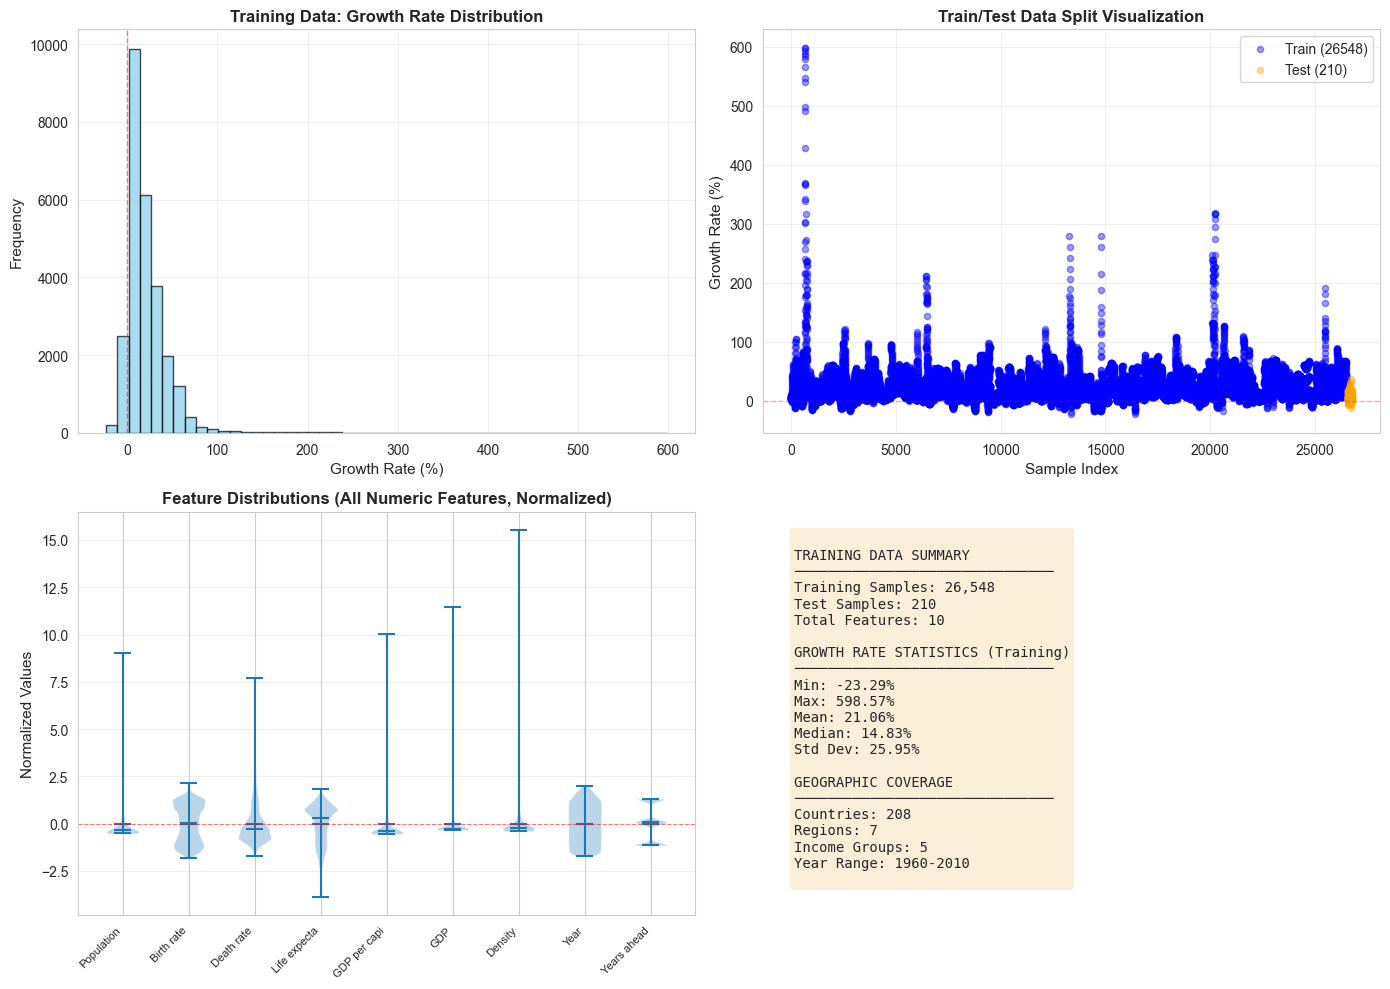


Data visualization saved to '../processed_data/data_visualization.png'


In [251]:
###############################################
# Data Visualization
###############################################

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("\n" + "="*70)
print("DATA VISUALIZATION")
print("="*70)

# 1. Target variable distribution and statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Growth rate distribution
axes[0, 0].hist(y_train, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Growth Rate (%)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Training Data: Growth Rate Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero Growth')

# Train vs Test split visualization
axes[0, 1].scatter(range(len(y_train)), y_train, alpha=0.4, s=20, label=f'Train ({len(y_train)})', color='blue')
axes[0, 1].scatter(range(len(y_train), len(y_train) + len(y_test)), y_test, alpha=0.4, s=20, label=f'Test ({len(y_test)})', color='orange')
axes[0, 1].set_xlabel('Sample Index', fontsize=11)
axes[0, 1].set_ylabel('Growth Rate (%)', fontsize=11)
axes[0, 1].set_title('Train/Test Data Split Visualization', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.3)

# Feature distributions - show all numeric features
X_train_display = X_train.copy()
# Select only numeric columns
numeric_cols = X_train_display.select_dtypes(include=[np.number]).columns.tolist()
X_train_numeric = X_train_display[numeric_cols].copy()

# Create a more comprehensive feature distribution visualization
# Use violin plot to show distribution shape
num_features = len(numeric_cols)
if num_features > 0:
    # Normalize for better visualization
    X_train_normalized = (X_train_numeric - X_train_numeric.mean()) / X_train_numeric.std()
    
    # Create violin plot with all features
    parts = axes[1, 0].violinplot(
        [X_train_normalized[col].dropna().values for col in numeric_cols],
        positions=range(num_features),
        showmeans=True,
        showmedians=True
    )
    
    axes[1, 0].set_xticks(range(num_features))
    axes[1, 0].set_xticklabels([col[:12] for col in numeric_cols], rotation=45, ha='right', fontsize=8)
    axes[1, 0].set_ylabel('Normalized Values', fontsize=11)
    axes[1, 0].set_title('Feature Distributions (All Numeric Features, Normalized)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Data summary statistics
axes[1, 1].axis('off')
min_growth = round(y_train.min(), 2)
max_growth = round(y_train.max(), 2)
mean_growth = round(y_train.mean(), 2)
median_growth = round(np.median(y_train), 2)
std_growth = round(y_train.std(), 2)
year_min = meta_train['Base Year'].min()
year_max = meta_train['Base Year'].max()

summary_text = f"""
TRAINING DATA SUMMARY
───────────────────────────────
Training Samples: {len(y_train):,}
Test Samples: {len(y_test):,}
Total Features: {X_train.shape[1]}

GROWTH RATE STATISTICS (Training)
───────────────────────────────
Min: {min_growth}%
Max: {max_growth}%
Mean: {mean_growth}%
Median: {median_growth}%
Std Dev: {std_growth}%

GEOGRAPHIC COVERAGE
───────────────────────────────
Countries: {meta_train['CCA3'].nunique()}
Regions: {meta_train['Region'].nunique()}
Income Groups: {meta_train['IncomeGroup'].nunique()}
Year Range: {year_min}-{year_max}
"""
axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../processed_data/data_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nData visualization saved to '../processed_data/data_visualization.png'")



MODEL PERFORMANCE VISUALIZATION


IndexError: index 3 is out of bounds for axis 1 with size 3

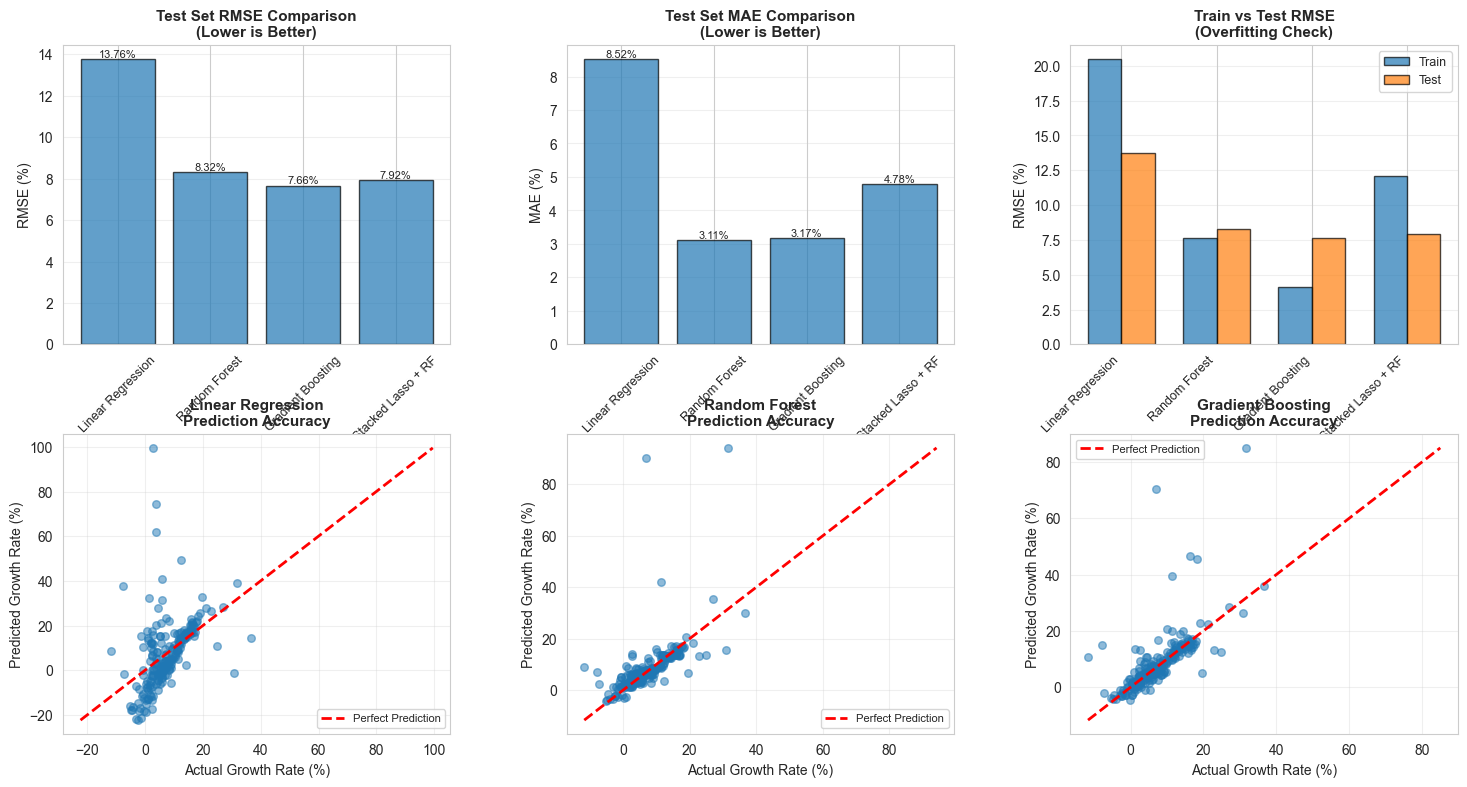

In [ ]:
###############################################
# Model Visualization - Learning Curves & Performance
###############################################

print("\n" + "="*70)
print("MODEL PERFORMANCE VISUALIZATION")
print("="*70)

# Import GridSpec for complex layout
from matplotlib.gridspec import GridSpec

# Model names
model_names = list(results.keys())
n_models = len(model_names)

# Create complex figure with dynamic grid based on number of models
# Row 1: 3 comparison plots (RMSE, MAE, Train vs Test)
# Row 2: n_models prediction scatter plots
# Row 3: n_models residual plots
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(3, max(3, n_models), figure=fig, hspace=0.3, wspace=0.3)

# Row 1: Model comparison metrics
# 1. Test RMSE comparison
ax1 = fig.add_subplot(gs[0, 0])
test_rmse_scores = [results[m]['test_rmse'] for m in model_names]
bars = ax1.bar(model_names, test_rmse_scores, alpha=0.7, edgecolor='black')
ax1.set_ylabel('RMSE (%)', fontsize=10)
ax1.set_title('Test Set RMSE Comparison\n(Lower is Better)', fontsize=11, fontweight='bold')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.grid(alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, test_rmse_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{val:.2f}%',
            ha='center', va='bottom', fontsize=8)

# 2. Test MAE comparison
ax2 = fig.add_subplot(gs[0, 1])
test_mae_scores = [results[m]['test_mae'] for m in model_names]
bars = ax2.bar(model_names, test_mae_scores, alpha=0.7, edgecolor='black')
ax2.set_ylabel('MAE (%)', fontsize=10)
ax2.set_title('Test Set MAE Comparison\n(Lower is Better)', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=9)
ax2.grid(alpha=0.3, axis='y')
for bar, val in zip(bars, test_mae_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{val:.2f}%',
            ha='center', va='bottom', fontsize=8)

# 3. Train vs Test RMSE
ax3 = fig.add_subplot(gs[0, 2])
x_pos = np.arange(len(model_names))
width = 0.35
train_rmse = [results[m]['train_rmse'] for m in model_names]
test_rmse = [results[m]['test_rmse'] for m in model_names]
ax3.bar(x_pos - width/2, train_rmse, width, label='Train', alpha=0.7, edgecolor='black')
ax3.bar(x_pos + width/2, test_rmse, width, label='Test', alpha=0.7, edgecolor='black')
ax3.set_ylabel('RMSE (%)', fontsize=10)
ax3.set_title('Train vs Test RMSE\n(Overfitting Check)', fontsize=11, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3, axis='y')

# Row 2: Prediction accuracy scatter plots
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[1, idx])
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    
    # Scatter plot
    ax.scatter(y_actual, y_pred, alpha=0.5, s=30)
    
    # Perfect prediction line
    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Growth Rate (%)', fontsize=10)
    ax.set_ylabel('Predicted Growth Rate (%)', fontsize=10)
    ax.set_title(f'{model_name}\nPrediction Accuracy', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Row 3: Residual plots
for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[2, idx])
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    residuals = y_actual - y_pred
    
    # Residual plot
    ax.scatter(y_pred, residuals, alpha=0.5, s=30)
    ax.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Error')
    
    ax.set_xlabel('Predicted Growth Rate (%)', fontsize=10)
    ax.set_ylabel('Residuals (%)', fontsize=10)
    ax.set_title(f'{model_name}\nResidual Analysis', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    
    # Add residual statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    ax.text(0.05, 0.95, f'Mean: {mean_res:.2f}%\nStd: {std_res:.2f}%', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Model Performance Comparison Across All Models', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('../processed_data/model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Model performance visualization saved to '../processed_data/model_performance.png'")

# Print detailed performance metrics table
print("\n" + "="*70)
print("DETAILED PERFORMANCE METRICS")
print("="*70)
for model_name in model_names:
    print(f"\n{model_name}:")
    train_mae = round(results[model_name]['train_mae'], 2)
    test_mae = round(results[model_name]['test_mae'], 2)
    train_rmse = round(results[model_name]['train_rmse'], 2)
    test_rmse = round(results[model_name]['test_rmse'], 2)
    
    print(f"  Train MAE:  {train_mae}%")
    print(f"  Test MAE:   {test_mae}%")
    print(f"  Train RMSE: {train_rmse}%")
    print(f"  Test RMSE:  {test_rmse}%")
    
    # Calculate residual statistics
    y_pred = results[model_name]['predictions']
    y_actual = results[model_name]['y_test']
    residuals = y_actual - y_pred
    mean_residual = round(np.mean(residuals), 2)
    std_residual = round(np.std(residuals), 2)
    print(f"  Mean Residual: {mean_residual}%")
    print(f"  Std Residual:  {std_residual}%")



FEATURE IMPORTANCE ANALYSIS (SHAP VALUES)

Computing SHAP values for Gradient Boosting model...
This may take a moment...
(Analyzing which features most influence growth rate predictions)



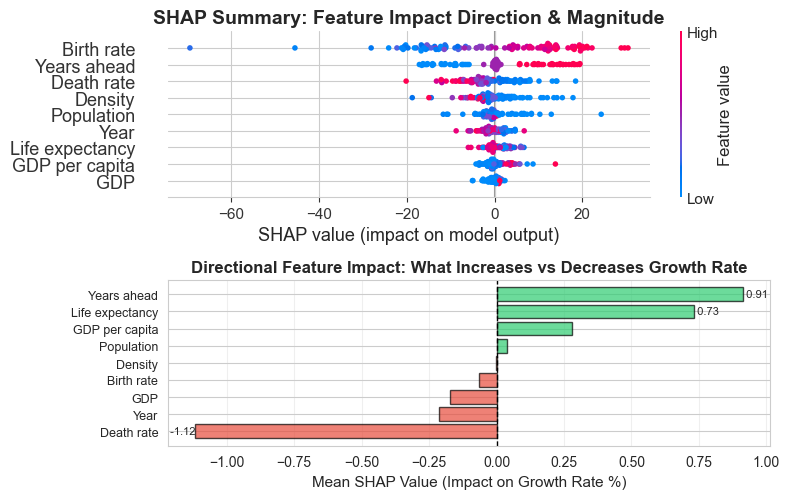

SHAP importance plot saved to '../processed_data/shap_importance.png'

DIRECTIONAL FEATURE IMPACTS ON GROWTH RATE

FEATURES THAT INCREASE GROWTH RATE (Positive Mean SHAP):
----------------------------------------------------------------------
  Years ahead: +0.9132 (pushes predictions UP)
  Life expectancy: +0.7312 (pushes predictions UP)
  GDP per capita: +0.2779 (pushes predictions UP)
  Population: +0.0404 (pushes predictions UP)

FEATURES THAT DECREASE GROWTH RATE (Negative Mean SHAP):
----------------------------------------------------------------------
  Density: -0.0008 (pushes predictions DOWN)
  Birth rate: -0.0649 (pushes predictions DOWN)
  GDP: -0.1732 (pushes predictions DOWN)
  Year: -0.2141 (pushes predictions DOWN)
  Death rate: -1.1158 (pushes predictions DOWN)

SHAP VALUE INTERPRETATION

SHAP (SHapley Additive exPlanations) values show directional feature impacts:

POSITIVE Mean SHAP = Feature pushes growth rate predictions UP on average
    Example: If "Birth rate" 

In [ ]:
###############################################
# SHAP Values - Feature Importance Analysis
###############################################
import shap

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS (SHAP VALUES)")
print("="*70)


# Use the best performing model (Gradient Boosting) for SHAP analysis
best_model_pipeline = models['Gradient Boosting']
# Extract the actual model from the pipeline
best_model = best_model_pipeline.named_steps['model']

print("\nComputing SHAP values for Gradient Boosting model...")
print("This may take a moment...")
print("(Analyzing which features most influence growth rate predictions)\n")

# Create SHAP explainer
# Use a sample of training data for faster computation
sample_size = min(100, len(X_train))
sample_idx = np.random.RandomState(42).choice(len(X_train), size=sample_size, replace=False)
X_sample = X_train.iloc[sample_idx]

# Preprocess the sample data using the pipeline's preprocessor
X_sample_preprocessed = best_model_pipeline.named_steps['preprocessor'].transform(X_sample)
X_sample_preprocessed_df = pd.DataFrame(X_sample_preprocessed, columns=X_sample.columns)

# TreeExplainer is most efficient for tree-based models
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample_preprocessed_df)

# Create SHAP visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1. Summary plot (dot plot) - shows distribution and direction of SHAP values
plt.sca(axes[0])
shap.summary_plot(shap_values, X_sample_preprocessed_df, show=False)
axes[0].set_title('SHAP Summary: Feature Impact Direction & Magnitude', fontsize=14, fontweight='bold')

# 2. Mean SHAP values (directional) - what pushes predictions up vs down
plt.sca(axes[1])
mean_shap = shap_values.mean(axis=0)
feature_names = X_sample_preprocessed_df.columns

# Sort by mean SHAP value
sorted_idx = np.argsort(mean_shap)
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_values = mean_shap[sorted_idx]

# Create horizontal bar chart with colors
colors_bar = ['#e74c3c' if val < 0 else '#2ecc71' for val in sorted_values]
y_pos = np.arange(len(sorted_features))

axes[1].barh(y_pos, sorted_values, color=colors_bar, edgecolor='black', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(sorted_features, fontsize=9)
axes[1].set_xlabel('Mean SHAP Value (Impact on Growth Rate %)', fontsize=11)
axes[1].set_title('Directional Feature Impact: What Increases vs Decreases Growth Rate', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')

# Add text annotations for extreme values
for i, (feat, val) in enumerate(zip(sorted_features, sorted_values)):
    if abs(val) > 0.5:  # Only annotate significant features
        val_rounded = round(val, 2)
        axes[1].text(val, i, f' {val_rounded}', va='center', 
                    ha='left' if val > 0 else 'right', fontsize=8)

plt.tight_layout()
plt.savefig('../processed_data/shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("SHAP importance plot saved to '../processed_data/shap_importance.png'")

# Print directional feature impacts
print("\n" + "="*70)
print("DIRECTIONAL FEATURE IMPACTS ON GROWTH RATE")
print("="*70)

# Calculate mean SHAP values (directional)
mean_shap_values = shap_values.mean(axis=0)
feature_impact_df = pd.DataFrame({
    'Feature': X_sample_preprocessed_df.columns,
    'Mean SHAP': mean_shap_values,
    'Impact': ['Increases Growth' if x > 0 else 'Decreases Growth' for x in mean_shap_values]
}).sort_values('Mean SHAP', ascending=False)

print("\nFEATURES THAT INCREASE GROWTH RATE (Positive Mean SHAP):")
print("-" * 70)
positive_features = feature_impact_df[feature_impact_df['Mean SHAP'] > 0]
if len(positive_features) > 0:
    for idx, row in positive_features.iterrows():
        shap_value = round(row['Mean SHAP'], 4)
        print(f"  {row['Feature']}: +{shap_value} (pushes predictions UP)")
else:
    print("  None")

print("\nFEATURES THAT DECREASE GROWTH RATE (Negative Mean SHAP):")
print("-" * 70)
negative_features = feature_impact_df[feature_impact_df['Mean SHAP'] < 0]
if len(negative_features) > 0:
    for idx, row in negative_features.iterrows():
        shap_value = round(row['Mean SHAP'], 4)
        print(f"  {row['Feature']}: {shap_value} (pushes predictions DOWN)")
else:
    print("  None")

print("\n" + "="*70)
print("SHAP VALUE INTERPRETATION")
print("="*70)
print("""
SHAP (SHapley Additive exPlanations) values show directional feature impacts:

POSITIVE Mean SHAP = Feature pushes growth rate predictions UP on average
    Example: If "Birth rate" has +2.5, it increases predicted growth rates

NEGATIVE Mean SHAP = Feature pulls growth rate predictions DOWN on average
    Example: If "Death rate" has -1.8, it decreases predicted growth rates

- The MAGNITUDE shows how strong the push/pull effect is
- In the dot plot: Red = high feature values, Blue = low feature values
- Dots to the RIGHT increase prediction, dots to the LEFT decrease it

This reveals what drives population growth vs what slows it down according to the model.
""")



In [ ]:
###############################################
# Prepare baseline data for multi-horizon predictions
###############################################

print("\n" + "="*70)
print("PREPARING LATEST AVAILABLE DATA FOR PREDICTIONS")
print("="*70)

# Find the latest year with data for each country
latest_year_per_country = df_merged.groupby('CCA3')['Year'].max().reset_index()
latest_year_per_country.columns = ['CCA3', 'Latest_Year']

# Get the most common latest year (should be 2016 from the data)
most_common_latest = latest_year_per_country['Latest_Year'].mode()[0]
print(f"\nMost common latest year in data: {most_common_latest}")

# Filter for the latest year data
df_merged_latest = df_merged[df_merged['Year'] == most_common_latest].copy()

print(f"Countries with {most_common_latest} data: {len(df_merged_latest)}")
print(f"Columns available: {df_merged_latest.shape[1]}")

# Helper function to make predictions for multiple horizons
def predict_population_multi_horizon(df_baseline, horizons, model_pipeline, training_columns):
    """
    Predict population for multiple future horizons based on baseline data.
    
    Args:
        df_baseline: DataFrame with baseline year data
        horizons: List of years ahead to predict (e.g., [5, 10, 15, 20])
        model_pipeline: Trained model pipeline (includes preprocessing)
        training_columns: List of column names used in training
    
    Returns:
        Dictionary mapping horizon -> (meta_df, growth_rates)
    """
    baseline_year = df_baseline['Year'].iloc[0]
    results = {}
    
    for years_ahead in horizons:
        target_year = baseline_year + years_ahead
        
        X_pred_list = []
        meta_pred_list = []
        
        for idx, row in df_baseline.iterrows():
            feature_row = {
                'Population': row['Population'],
                'Birth rate': row.get('Birth rate, crude (per 1,000 people)', np.nan),
                'Death rate': row.get('Death rate, crude (per 1,000 people)', np.nan),
                'Life expectancy': row.get('Life expectancy at birth (years)', np.nan),
                'GDP per capita': row.get('GDP per capita (USD)', np.nan),
                'GDP': row.get('GDP (USD)', np.nan),
                'Density': row.get('Population density (people per sq. km of land area)', np.nan),
                'Year': baseline_year,
                'Years ahead': years_ahead
            }
            
            X_pred_list.append(feature_row)
            meta_pred_list.append({
                'Country Name': row['Country Name'],
                'CCA3': row['CCA3'],
                'Region': row.get('Region', 'Unknown'),
                'IncomeGroup': row.get('IncomeGroup', 'Unknown'),
                f'Population_{baseline_year}': row['Population']
            })
        
        X_pred = pd.DataFrame(X_pred_list)
        meta_pred = pd.DataFrame(meta_pred_list)
        
        # Reorder to match training columns
        X_pred = X_pred[training_columns]
        
        # Predict growth rates using the pipeline
        predicted_growth_rates = model_pipeline.predict(X_pred)
        
        # Calculate predicted population
        meta_pred['Years_Ahead'] = years_ahead
        meta_pred['Target_Year'] = target_year
        meta_pred['Predicted_Growth_Rate'] = predicted_growth_rates
        meta_pred[f'Predicted_Population_{target_year}'] = meta_pred[f'Population_{baseline_year}'] * (1 + predicted_growth_rates / 100)
        
        results[years_ahead] = (meta_pred, predicted_growth_rates)
    
    return results

# Make predictions for 5, 10, and 15 years ahead
print("\nGenerating predictions for multiple horizons...")
prediction_horizons = [5, 10, 15]

prediction_results = predict_population_multi_horizon(
    df_merged_latest, 
    prediction_horizons, 
    best_model_pipeline, 
    training_columns
)

# Save predictions for each horizon
for years_ahead, (meta_df, growth_rates) in prediction_results.items():
    target_year = most_common_latest + years_ahead
    output_file = f'../processed_data/population_predictions_{target_year}.csv'
    meta_df.to_csv(output_file, index=False)
    avg_growth = round(growth_rates.mean(), 2)
    sign = '+' if avg_growth >= 0 else ''
    print(f"  {target_year} ({years_ahead} years ahead): Avg growth = {sign}{avg_growth}%, File: {output_file}")

print("\nAll prediction files generated successfully!")


PREPARING LATEST AVAILABLE DATA FOR PREDICTIONS

Most common latest year in data: 2016
Countries with 2016 data: 210
Columns available: 18

Generating predictions for multiple horizons...
  2021 (5 years ahead): Avg growth = +8.39%, File: ../processed_data/population_predictions_2021.csv
  2026 (10 years ahead): Avg growth = +17.71%, File: ../processed_data/population_predictions_2026.csv
  2031 (15 years ahead): Avg growth = +27.85%, File: ../processed_data/population_predictions_2031.csv

All prediction files generated successfully!



VISUALIZING MULTI-HORIZON POPULATION PREDICTIONS

Baseline year: 2016
Prediction horizons: [5, 10, 15]
Target years: [2021, 2026, 2031]

Combined prediction data shape: (210, 11)
Average growth rates by horizon:
  5 years: +8.39%
  10 years: +17.71%
  15 years: +27.85%


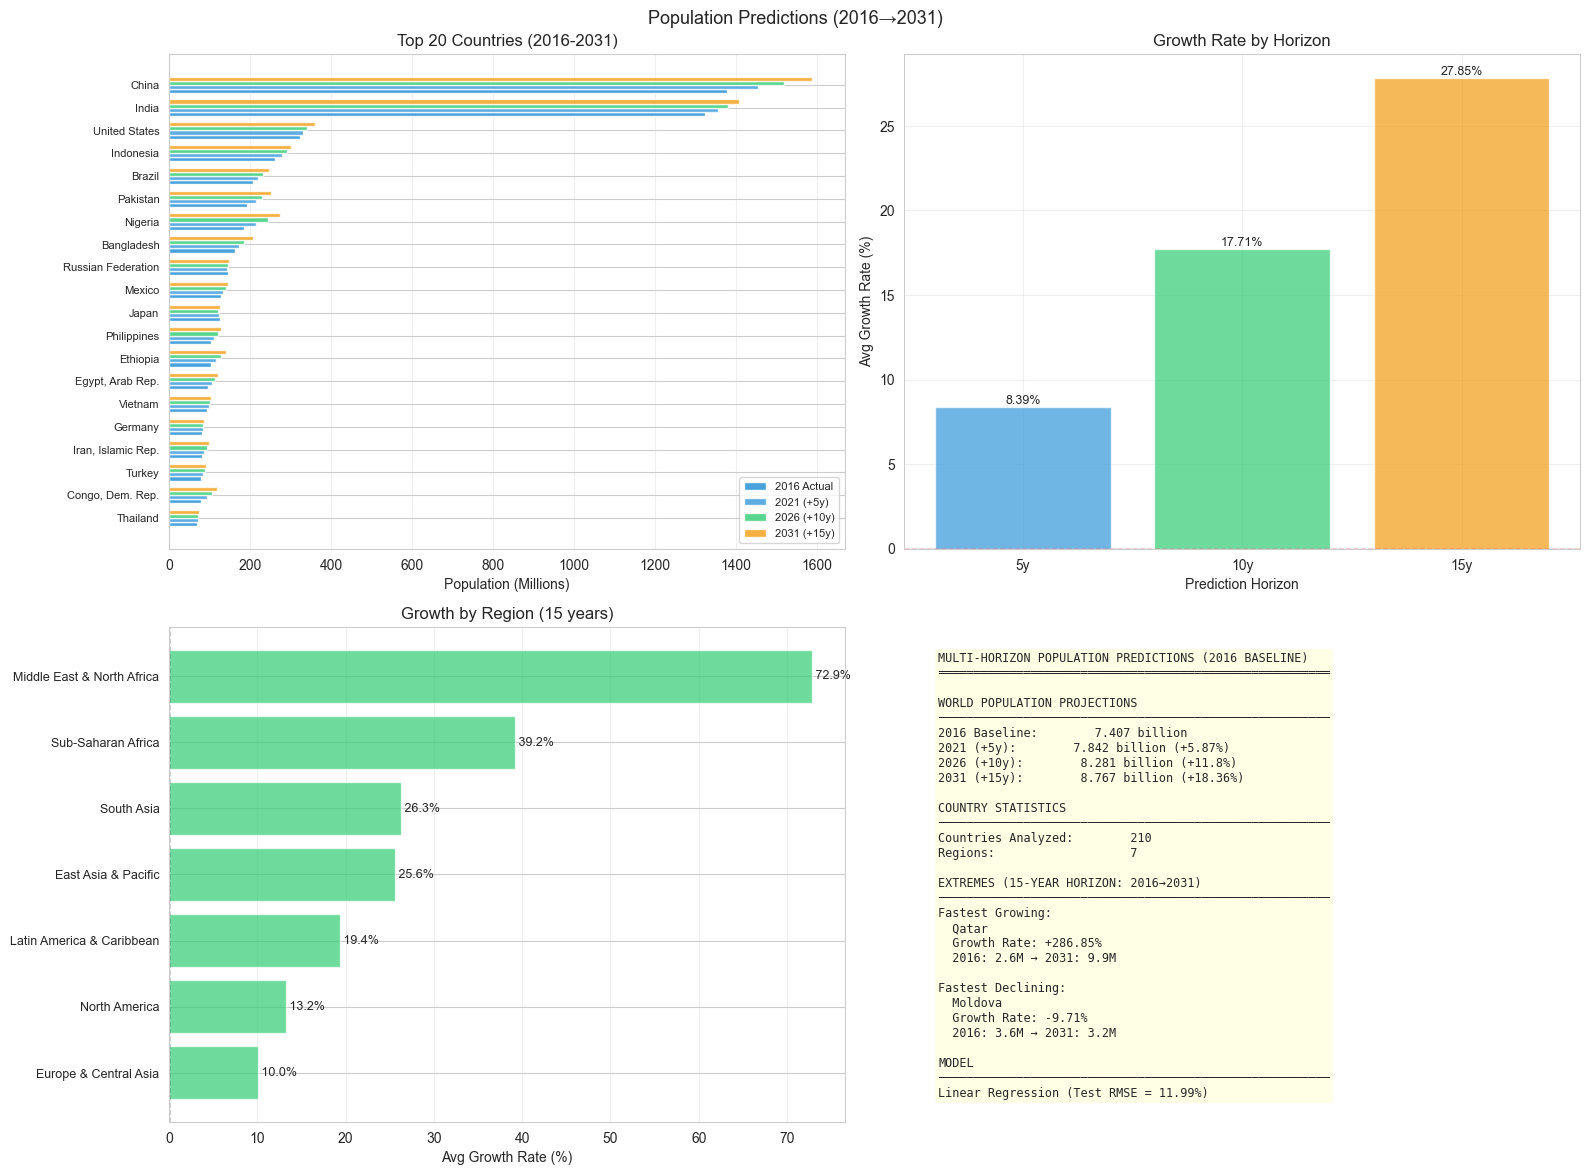


Visualization saved to '../processed_data/population_prediction_multi_horizon.png'

TOP 10 COUNTRIES BY 2016 POPULATION - MULTI-HORIZON PREDICTIONS
Rank  Country                    2016        2021        2026        2031
--------------------------------------------------------------------------------
1. China                1378.7M  1455.8M  1518.8M  1589.6M
2. India                1324.2M  1355.6M  1379.8M  1407.2M
3. United States        323.1M  331.9M  341.1M  359.8M
4. Indonesia            261.1M  278.3M  290.8M  300.6M
5. Brazil               207.7M  219.8M  230.8M  246.8M
6. Pakistan             193.2M  213.8M  230.1M  251.4M
7. Nigeria              186.0M  215.3M  245.4M  274.1M
8. Bangladesh           163.0M  171.6M  184.0M  206.7M
9. Russian Federation   144.3M  143.7M  145.7M  149.2M
10. Mexico               127.5M  133.4M  139.5M  144.6M

GROWTH RATES BY HORIZON (TOP 10 COUNTRIES)
Rank  Country                 5y   10y   15y
------------------------------------------------

In [ ]:
###############################################
# Multi-Horizon Population Predictions Visualization
###############################################

print("\n" + "="*70)
print("VISUALIZING MULTI-HORIZON POPULATION PREDICTIONS")
print("="*70)

# Get baseline year and predictions
baseline_year = most_common_latest
horizons = sorted(prediction_results.keys())
target_years = [int(baseline_year + h) for h in horizons]

print(f"\nBaseline year: {baseline_year}")
print(f"Prediction horizons: {horizons}")
print(f"Target years: {target_years}")

# Extract data for visualization
meta_baseline = df_merged_latest[['Country Name', 'CCA3', 'Region', 'IncomeGroup', 'Population']].copy()
meta_baseline.columns = ['Country Name', 'CCA3', 'Region', 'IncomeGroup', f'Population_{baseline_year}']

# Add predictions for each horizon
for years_ahead in horizons:
    meta_pred, growth_rates = prediction_results[years_ahead]
    target_year = baseline_year + years_ahead
    
    meta_baseline[f'Growth_Rate_{years_ahead}y'] = growth_rates
    meta_baseline[f'Population_{target_year}'] = meta_pred[f'Predicted_Population_{target_year}'].values

print(f"\nCombined prediction data shape: {meta_baseline.shape}")
print(f"Average growth rates by horizon:")
for years_ahead in horizons:
    avg_growth = round(meta_baseline[f'Growth_Rate_{years_ahead}y'].mean(), 2)
    sign = '+' if avg_growth >= 0 else ''
    print(f"  {years_ahead} years: {sign}{avg_growth}%")

# Create simpler multi-horizon visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 countries - population trajectories across all horizons
top_20 = meta_baseline.nlargest(20, f'Population_{baseline_year}').sort_values(f'Population_{baseline_year}', ascending=True)
y_pos = np.arange(len(top_20))

ax1 = axes[0, 0]
colors_horizons = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bar_width = 0.18

ax1.barh(y_pos - 1.5*bar_width, top_20[f'Population_{baseline_year}'] / 1e6, bar_width, 
         label=f'{baseline_year} Actual', color=colors_horizons[0], alpha=0.9)

for i, (years_ahead, color) in enumerate(zip(horizons, colors_horizons)):
    target_year = baseline_year + years_ahead
    offset = (-0.5 + i) * bar_width
    ax1.barh(y_pos + offset, top_20[f'Population_{target_year}'] / 1e6, bar_width,
             label=f'{target_year} (+{years_ahead}y)', color=color, alpha=0.8)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_20['Country Name'], fontsize=8)
ax1.set_xlabel('Population (Millions)')
ax1.set_title(f'Top 20 Countries ({baseline_year}-{baseline_year+15})')
ax1.legend(fontsize=8, loc='lower right')
ax1.grid(alpha=0.3, axis='x')

# 2. Growth rates by horizon comparison
ax2 = axes[0, 1]
x_horizon = np.arange(len(horizons))
avg_growth_by_horizon = [meta_baseline[f'Growth_Rate_{h}y'].mean() for h in horizons]
std_growth_by_horizon = [meta_baseline[f'Growth_Rate_{h}y'].std() for h in horizons]

bars = ax2.bar(x_horizon, avg_growth_by_horizon, color=colors_horizons[:len(horizons)], alpha=0.7)
ax2.set_xticks(x_horizon)
ax2.set_xticklabels([f'{h}y' for h in horizons])
ax2.set_xlabel('Prediction Horizon')
ax2.set_ylabel('Avg Growth Rate (%)')
ax2.set_title('Growth Rate by Horizon')
ax2.grid(alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)

for bar, val in zip(bars, avg_growth_by_horizon):
    height = bar.get_height()
    val_rounded = round(val, 2)
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{val_rounded}%', 
             ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

# 3. Growth rate by region for 15-year horizon
ax3 = axes[1, 0]
regions_growth = meta_baseline.groupby('Region').agg({
    f'Population_{baseline_year}': 'sum',
    f'Growth_Rate_{horizons[-1]}y': 'mean'  # Use longest horizon
}).reset_index().sort_values(f'Growth_Rate_{horizons[-1]}y', ascending=True)

y_pos_region = np.arange(len(regions_growth))
colors_region = ['#e74c3c' if val < 0 else '#2ecc71' for val in regions_growth[f'Growth_Rate_{horizons[-1]}y']]

bars = ax3.barh(y_pos_region, regions_growth[f'Growth_Rate_{horizons[-1]}y'], 
                color=colors_region, alpha=0.7)
ax3.set_yticks(y_pos_region)
ax3.set_yticklabels(regions_growth['Region'], fontsize=9)
ax3.set_xlabel('Avg Growth Rate (%)')
ax3.set_title(f'Growth by Region ({horizons[-1]} years)')
ax3.grid(alpha=0.3, axis='x')
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)

for bar, val in zip(bars, regions_growth[f'Growth_Rate_{horizons[-1]}y']):
    width = bar.get_width()
    val_rounded = round(val, 1)
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
             f' {val_rounded}%', ha='left' if val > 0 else 'right', va='center', fontsize=9)

# 4. Summary statistics table with multi-horizon information
ax4 = axes[1, 1]
ax4.axis('off')

total_baseline = meta_baseline[f'Population_{baseline_year}'].sum()
total_projections = {h: meta_baseline[f'Population_{baseline_year+h}'].sum() for h in horizons}

# Find extremes for longest horizon
longest_horizon = horizons[-1]
fastest_growing = meta_baseline.nlargest(1, f'Growth_Rate_{longest_horizon}y').iloc[0]
fastest_declining = meta_baseline.nsmallest(1, f'Growth_Rate_{longest_horizon}y').iloc[0]

# Build summary text
baseline_pop_billions = round(total_baseline / 1e9, 3)
summary_lines = [
    f"MULTI-HORIZON POPULATION PREDICTIONS ({baseline_year} BASELINE)",
    "═" * 55,
    "",
    "WORLD POPULATION PROJECTIONS",
    "─" * 55,
    f"{baseline_year} Baseline:        {baseline_pop_billions} billion"
]

for years_ahead in horizons:
    target_year = baseline_year + years_ahead
    total_pop = total_projections[years_ahead]
    total_pop_billions = round(total_pop / 1e9, 3)
    growth = round(((total_pop - total_baseline) / total_baseline) * 100, 2)
    sign = '+' if growth >= 0 else ''
    summary_lines.append(f"{target_year} (+{years_ahead}y):        {total_pop_billions} billion ({sign}{growth}%)")

growing_rate = round(fastest_growing[f'Growth_Rate_{longest_horizon}y'], 2)
growing_rate_sign = '+' if growing_rate >= 0 else ''
growing_pop_start = round(fastest_growing[f'Population_{baseline_year}'] / 1e6, 1)
growing_pop_end = round(fastest_growing[f'Population_{baseline_year+longest_horizon}'] / 1e6, 1)

declining_rate = round(fastest_declining[f'Growth_Rate_{longest_horizon}y'], 2)
declining_rate_sign = '+' if declining_rate >= 0 else ''
declining_pop_start = round(fastest_declining[f'Population_{baseline_year}'] / 1e6, 1)
declining_pop_end = round(fastest_declining[f'Population_{baseline_year+longest_horizon}'] / 1e6, 1)

model_rmse = round(results[best_model_name]['test_rmse'], 2)

summary_lines.extend([
    "",
    "COUNTRY STATISTICS",
    "─" * 55,
    f"Countries Analyzed:        {len(meta_baseline)}",
    f"Regions:                   {meta_baseline['Region'].nunique()}",
    "",
    f"EXTREMES (15-YEAR HORIZON: {baseline_year}→{baseline_year+longest_horizon})",
    "─" * 55,
    f"Fastest Growing:",
    f"  {fastest_growing['Country Name'][:35]}",
    f"  Growth Rate: {growing_rate_sign}{growing_rate}%",
    f"  {baseline_year}: {growing_pop_start}M → {baseline_year+longest_horizon}: {growing_pop_end}M",
    "",
    f"Fastest Declining:",
    f"  {fastest_declining['Country Name'][:35]}",
    f"  Growth Rate: {declining_rate_sign}{declining_rate}%",
    f"  {baseline_year}: {declining_pop_start}M → {baseline_year+longest_horizon}: {declining_pop_end}M",
    "",
    "MODEL",
    "─" * 55,
    f"{best_model_name} (Test RMSE = {model_rmse}%)"
])

summary_text = "\n".join(summary_lines)

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=8.5, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle(f'Population Predictions ({baseline_year}→{baseline_year+15})', fontsize=13)
plt.tight_layout()
plt.savefig('../processed_data/population_prediction_multi_horizon.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to '../processed_data/population_prediction_multi_horizon.png'")

# Print detailed predictions for top 10 countries
print("\n" + "="*80)
print(f"TOP 10 COUNTRIES BY {baseline_year} POPULATION - MULTI-HORIZON PREDICTIONS")
print("="*80)

top_10 = meta_baseline.nlargest(10, f'Population_{baseline_year}')

# Print header
header = f"{'Rank':<5} {'Country':<20} {baseline_year:>10}"
for years_ahead in horizons:
    target_year = baseline_year + years_ahead
    header += f"  {target_year:>10}"
print(header)
print("-" * 80)

# Print each country's trajectory
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    pop_baseline = round(row[f'Population_{baseline_year}'] / 1e6, 1)
    country_name = row['Country Name'][:19]
    line = f"{i}. {country_name:20s} {pop_baseline}M"
    for years_ahead in horizons:
        target_year = baseline_year + years_ahead
        pop = round(row[f'Population_{target_year}'] / 1e6, 1)
        line += f"  {pop}M"
    print(line)

print("\n" + "="*80)
print("GROWTH RATES BY HORIZON (TOP 10 COUNTRIES)")
print("="*80)

# Print growth rates
header = f"{'Rank':<5} {'Country':<20}"
for years_ahead in horizons:
    header += f"  {years_ahead:>3}y"
print(header)
print("-" * 80)

for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    country_name = row['Country Name'][:19]
    line = f"{i}. {country_name:20s}"
    for years_ahead in horizons:
        growth = round(row[f'Growth_Rate_{years_ahead}y'], 2)
        line += f"  {growth}%"
    print(line)

print("\n" + "="*80)
print("SUMMARY STATISTICS BY PREDICTION HORIZON")
print("="*80)
print(f"\n{'Horizon':<15} {'Avg Growth %':<15} {'Countries Growing':<20} {'Countries Declining':<20}")
print("-" * 80)

for years_ahead in horizons:
    avg_growth = round(meta_baseline[f'Growth_Rate_{years_ahead}y'].mean(), 2)
    n_growing = (meta_baseline[f'Growth_Rate_{years_ahead}y'] > 0).sum()
    n_declining = (meta_baseline[f'Growth_Rate_{years_ahead}y'] < 0).sum()
    pct_growing = round((n_growing / len(meta_baseline)) * 100, 1)
    pct_declining = round((n_declining / len(meta_baseline)) * 100, 1)
    
    print(f"{years_ahead} years: {avg_growth}%  |  Growing: {n_growing} ({pct_growing}%)  |  Declining: {n_declining} ({pct_declining}%)")

# Print top 10 declining countries (10-year horizon: 2016 to 2026)
print("\n" + "="*80)
print(f"TOP 10 DECLINING COUNTRIES ({baseline_year}→{baseline_year+10}, 10-YEAR HORIZON)")
print("="*80)

# Get 10-year growth rates and sort by most negative
ten_year_horizon = 10
bottom_10 = meta_baseline.nsmallest(10, f'Growth_Rate_{ten_year_horizon}y')

# Create properly formatted column headers
start_year = baseline_year
end_year = baseline_year + ten_year_horizon
print(f"\n{'Rank':<5} {'Country':<25} {f'Pop {start_year} (M)':<18} {f'Pop {end_year} (M)':<18} {'Growth Rate':<15} {'Population Loss'}")
print("-" * 80)

for i, (idx, row) in enumerate(bottom_10.iterrows(), 1):
    country_name = row['Country Name'][:24]
    pop_start = round(row[f'Population_{baseline_year}'] / 1e6, 2)
    pop_end = round(row[f'Population_{baseline_year+ten_year_horizon}'] / 1e6, 2)
    growth_rate = round(row[f'Growth_Rate_{ten_year_horizon}y'], 2)
    pop_loss = round((pop_start - pop_end), 2)
    
    print(f"{i:<5} {country_name:<25} {pop_start:<18.2f} {pop_end:<18.2f} {growth_rate:<15.2f}% {pop_loss:.2f}M")

In [ ]:
###############################################
# Interactive Country Prediction Lookup
###############################################

print("\n" + "="*70)
print("INTERACTIVE COUNTRY PREDICTION LOOKUP")
print("="*70)

def lookup_country_prediction():
    """
    Interactive function to look up population predictions for a specific country across all horizons.
    """
    print("\nThis will show predictions for 2021, 2026, and 2031")
    print("(Based on 2016 baseline + 5, 10, and 15 years)")
    
    # Get user input
    country_name = input("\nEnter country name (e.g., 'United States', 'China', 'India'): ").strip()
    
    if not country_name:
        print("\nError: Please enter a country name.")
        return
    
    # All prediction years
    prediction_years = [2021, 2026, 2031]
    baseline_year = 2016
    
    try:
        # Load all prediction files and search for the country
        all_predictions = {}
        
        for year in prediction_years:
            csv_file = f'../processed_data/population_predictions_{year}.csv'
            df = pd.read_csv(csv_file)
            
            # Search for the country (case-insensitive partial match)
            matching = df[df['Country Name'].str.contains(country_name, case=False, na=False)]
            
            if len(matching) > 0:
                all_predictions[year] = matching
        
        # Check if any matches found
        if not all_predictions:
            print(f"\nNo countries found matching '{country_name}'")
            print("\nHint: Try searching for partial names (e.g., 'United' for 'United States')")
            return
        
        # Get the first matching country from the first prediction file
        first_year = list(all_predictions.keys())[0]
        matching_countries = all_predictions[first_year]
        
        if len(matching_countries) > 1:
            print(f"\nFound {len(matching_countries)} countries matching '{country_name}':")
            for idx, row in matching_countries.iterrows():
                print(f"  - {row['Country Name']}")
            print("\nShowing predictions for all matches:\n")
        
        # Display results for each matching country
        for idx, country_row in matching_countries.iterrows():
            country_full_name = country_row['Country Name']
            
            print("\n" + "="*70)
            print(f"PREDICTIONS FOR: {country_full_name.upper()}")
            print("="*70)
            
            print(f"\nCountry: {country_full_name}")
            print(f"   Region: {country_row['Region']}")
            print(f"   Income Group: {country_row['IncomeGroup']}")
            
            # Get baseline population
            pop_baseline = round(country_row[f'Population_{baseline_year}'] / 1e6, 2)
            print(f"\n{baseline_year} Baseline Population: {pop_baseline} million")
            
            print("\n" + "-"*70)
            print(f"{'Year':<10} {'Horizon':<12} {'Population':<18} {'Growth Rate':<15} {'Change'}")
            print("-"*70)
            
            # Show predictions for all years
            for year in prediction_years:
                if year in all_predictions:
                    year_df = all_predictions[year]
                    country_data = year_df[year_df['Country Name'] == country_full_name]
                    
                    if len(country_data) > 0:
                        row = country_data.iloc[0]
                        years_ahead = row['Years_Ahead']
                        pop_predicted = round(row[f'Predicted_Population_{year}'] / 1e6, 2)
                        growth_rate = round(row['Predicted_Growth_Rate'], 2)
                        pop_change = round(pop_predicted - pop_baseline, 2)
                        
                        growth_sign = '+' if growth_rate >= 0 else ''
                        change_sign = '+' if pop_change >= 0 else ''
                        
                        print(f"{year:<10} +{years_ahead} years{' ':<3} {pop_predicted} M{' ':<11} {growth_sign}{growth_rate}%{' ':<10} {change_sign}{pop_change} M")
            
            print("-"*70)
            
            # Summary
            if 2031 in all_predictions:
                final_year_df = all_predictions[2031]
                final_data = final_year_df[final_year_df['Country Name'] == country_full_name]
                
                if len(final_data) > 0:
                    final_growth = round(final_data.iloc[0]['Predicted_Growth_Rate'], 2)
                    final_pop_change = round(final_data.iloc[0][f'Predicted_Population_2031'] / 1e6 - pop_baseline, 2)
                    
                    if final_growth > 0:
                        print(f"\nOver 15 years (2016→2031): Population projected to GROW by {abs(final_pop_change):.2f} million ({final_growth:+.2f}%)")
                    else:
                        print(f"\nOver 15 years (2016→2031): Population projected to DECLINE by {abs(final_pop_change):.2f} million ({final_growth:.2f}%)")
    
    except FileNotFoundError as e:
        print(f"\nError: Prediction file not found: {e}")
        print("Make sure you've run the prediction cells first!")
    except Exception as e:
        print(f"\nError: {str(e)}")

# Run the interactive lookup
lookup_country_prediction()

# Optional: Allow multiple lookups
print("\n" + "="*70)
while True:
    response = input("\nDo you want to look up another country? (yes/no): ").strip().lower()
    if response in ['yes', 'y']:
        lookup_country_prediction()
    else:
        print("\nLookup complete!")
        break


INTERACTIVE COUNTRY PREDICTION LOOKUP

This will show predictions for 2021, 2026, and 2031
(Based on 2016 baseline + 5, 10, and 15 years)

PREDICTIONS FOR: JAPAN

Country: Japan
   Region: East Asia & Pacific
   Income Group: High income: OECD

2016 Baseline Population: 126.99 million

----------------------------------------------------------------------
Year       Horizon      Population         Growth Rate     Change
----------------------------------------------------------------------
2021       +5 years    123.42 M            -2.81%           -3.57 M
2026       +10 years    121.38 M            -4.42%           -5.61 M
2031       +15 years    126.08 M            -0.72%           -0.91 M
----------------------------------------------------------------------

Over 15 years (2016→2031): Population projected to DECLINE by 0.91 million (-0.72%)


PREDICTIONS FOR: JAPAN

Country: Japan
   Region: East Asia & Pacific
   Income Group: High income: OECD

2016 Baseline Population: 126.99 m